# Predicting AirBnB prices using Stacking Regression Models

This project builds and compares the performance of several linear model algorithms used for predicing AirBnB listing prices in New York City.

First, four different types of models were each independently trained using a preprocessed dataset of about 28,000 AirBnB listings with 50 features (columns). Since there was a moderate amount of variance, I used Root Mean Squared Error (RSME)  to evaluate the performance of the models since it measure the absolute fit. R-squared was calculated as a secondary performance metric since it measures relative fit.

Second, a stacking model was built to combine all four of the independent models into a single ensemble model. A Grid Search to find the optimal RSME given a list of hyperparameters. The optimal model was evaluated in more detail.

Finally, the performance of all the models was visualized and compared.

The stacking model performed the best because it had the lowest RSME. The RSME of 0.62 on a scale of -1 to 6, or about 9% of the total range, is acceptble but could use improvement. More time could be spent further optimizing the hyperparameter values, but training times were significantly increasing with only 0.1% performance improvement. The optimal model's R-squared value was 0.64. The prices in the public dataset were normalized (mean was 0 and stddev was 1), so re-mapping the prices back to dollars would likely result in the price predictions having more noticible error in dollars.

The second best model, the Random Forest, took 91% less time to train and was close in performance. The Random Forest model would probably be a fine substitute for lower cost applications.

The prediction vs ground truth is plotted below. As the ground truth price increased, so did the error. The model performs well at predicting the prices for AirBnB units almost the whole price range, but underestimate the price for the top 4% AirBnB units.

Ideas for future work are listed at the bottom of this notebook.

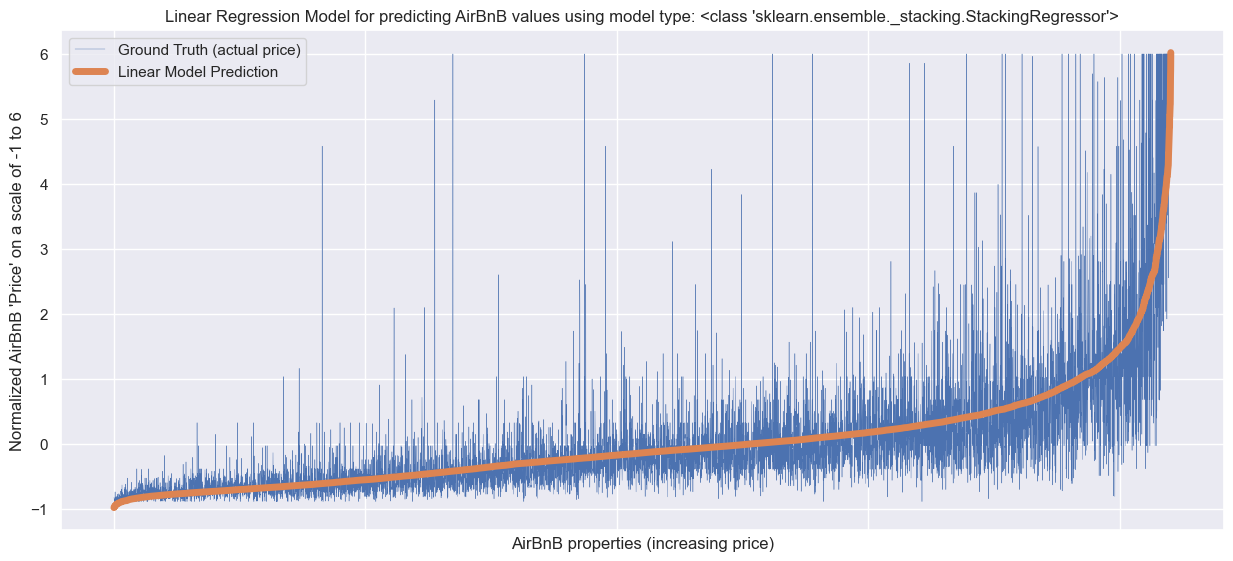

In [44]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

%load_ext Cython
import numba
numba.set_num_threads(4)
import pyarrow as pa
import pyarrow.parquet as pq

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv.gz")

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### Load the Data and split it into Training and Test Sets

In [15]:
df = pd.read_csv(filename, header=0,
                  dtype_backend='pyarrow',
                  engine='pyarrow')         

# in this project, the label (output) column being studied is the price.
y = df['price']
X = df.drop(columns = 'price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=1234)

## Fit and Evaluate Individual Regression Models

### Individual Model: Linear Regression

Training times on Macbook Pro:
* 40.9 ms ± 20.2 ms per loop (mean ± std. dev. of 50 runs, 1 loop each)
* 33.7 ms ± 8.85 ms per loop (mean ± std. dev. of 500 runs, 1 loop each) with n_jobs=-1
* 180 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) with n_jobs=-1 and pyarrow backend

[comment]: <> (Performance:)
 [comment]: <> (* Root Mean Squared Error: 0.7449)
 [comment]: <> (* R2: 0.4744)

In [16]:
lr_model = LinearRegression(n_jobs=-1)

# train the model and display the training time
%timeit -n1 -r1 lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_lr_pred = lr_model.predict(X_test)

# Compute the RMSE and R2
lr_rmse = np.sqrt(mean_squared_error(y_test, y_lr_pred))
lr_r2 = r2_score(y_test, y_lr_pred)

print(f'[LR] Root Mean Squared Error: {round(lr_rmse, 4)}')
print(f'[LR] R2: {round(lr_r2, 4)}')

124 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
[LR] Root Mean Squared Error: 0.7449
[LR] R2: 0.4744


### Individual Model: Decision Tree 
In a previous project, I ran a grid search to find the best model hyperparameters for the decision tree. 
The best values were: `max_depth=8`, and `min_samples_leaf = 50`.

Training times on Macbook Pro: 
 * 117 ms ± 12.1 ms per loop (mean ± std. dev. of 50 runs, 1 loop each)
 * 166 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) with pyarrow backend

[comment]: <> (Performance:)
[comment]: <> ( * Root Mean Squared Error: 0.7351)
 [comment]: <> (* R2: 0.4882)

In [17]:
# parallel processing (n_jobs) is not available for DecisionTreeRegressor
dt_model = DecisionTreeRegressor(max_depth=8, min_samples_leaf=50)

# train the model and display the training time
%timeit -n1 -r1 dt_model.fit(X_train, y_train)

# make predictions on the test data.
y_dt_pred = dt_model.predict(X_test)

# Compute the RMSE and R2
dt_rmse = np.sqrt(mean_squared_error(y_test, y_dt_pred))
dt_r2 = r2_score(y_test, y_dt_pred)

print(f'[DT] Root Mean Squared Error: {round(dt_rmse, 4)}')
print(f'[DT] R2: {round(dt_r2, 4)}')

171 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
[DT] Root Mean Squared Error: 0.7351
[DT] R2: 0.4881


### Individual Model: Gradient Boosted Decision Tree 

In a previous project, I ran a grid search to find the best model hyperparameters for the gradient boosted decision tree.
The best values were: `max_depth=2`, and `n_estimators = 300`.

 Training times on Macbook Pro: 
  * 9.55 s ± 348 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
  * 9.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) with pyarrow backend

[comment]: <> (Performance)
[comment]: <> ( * Root Mean Squared Error: 0.6606)
[comment]: <> ( * R2: 0.5864)

In [18]:
# parallel processing (n_jobs) is not available for GradientBoostingRegressor
gbdt_model = GradientBoostingRegressor(max_depth=2, n_estimators=300)

# Fit the model to the training data
%timeit -n1 -r1 gbdt_model.fit(X_train, y_train)

# Make predictions on the test data
y_gbdt_pred = gbdt_model.predict(X_test)

# Compute the RMSE and R2
gbdt_rmse = np.sqrt(mean_squared_error(y_test, y_gbdt_pred))
gbdt_r2   = r2_score(y_test, y_gbdt_pred)

print(f'[GBDT] Root Mean Squared Error: {round(gbdt_rmse, 4)}')
print(f'[GBDT] R2: {round(gbdt_r2, 4)}')

9.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
[GBDT] Root Mean Squared Error: 0.6607
[GBDT] R2: 0.5865


### Individual Model: Random Forest

Training times on Macbook Pro:
 * 1min 13s ± 1.27 s per loop (mean ± std. dev. of 5 runs, 1 loop each)
 * 20.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) when n_jobs=-1 with default backend
 * 14.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) when n_jobs=-1 and pyarrow backend
 
[comment]: <> (Performance:)
[comment]: <> ( * Root Mean Squared Error: 0.6289)
[comment]: <> ( * R2: 0.6254)

In [19]:
rf_model = RandomForestRegressor(max_depth=32, n_estimators=300, n_jobs=-1)

# Fit the model to the training data
%timeit -n1 -r1 rf_model.fit(X_train, y_train)

# make predictions on the test data
y_rf_pred = rf_model.predict(X_test)

# Compute RMSE and R2
rf_rmse = np.sqrt(mean_squared_error(y_test, y_rf_pred))
rf_r2   = r2_score(y_test, y_rf_pred)

print(f'[RF] Root Mean Squared Error: {round(rf_rmse, 4)}')
print(f'[RF] R2: {round(rf_r2, 4)}')

17.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
[RF] Root Mean Squared Error: 0.63
[RF] R2: 0.6241


## Combining the individual models into a single Stacking Model

Running a variety of hyperparameter combinations to find which one has the lowest RSME.

In [ ]:
estimators = [
    ("LR",   LinearRegression()),
    ("DT",   DecisionTreeRegressor()),
    ("RF",   RandomForestRegressor()),
    ("GBDT", GradientBoostingRegressor()),
    ]

stacking_model = StackingRegressor(estimators=estimators, cv=5, passthrough=False)

params = {
    "DT__max_depth":        [4, 8, 16],                    
    "GBDT__max_depth":      [4, 8, 16],                    
    "DT__min_samples_leaf": [50, 100, 250],
    "RF__max_depth":        [4, 8, 16],
    "RF__n_estimators":     [100, 200],             
    "GBDT__n_estimators":   [100, 200],             
}

# scoring = {"NRSME": "neg_root_mean_squared_error", "R2": make_scorer(r2_score)}
# stack_grid = GridSearchCV(stacking_model, params, cv=3, verbose=4, scoring=scoring, refit='NRSME', return_train_score=True, n_jobs=-1)
stack_grid = GridSearchCV(stacking_model, params, cv=3, verbose=4, scoring='neg_root_mean_squared_error', n_jobs=-1)
stack_grid.fit(X_train, y_train)

## Evaluating the optimal Stacking Model

 * 2min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 * Root Mean Squared Error: 0.6206763671097633
 * R2: 0.6351118454144045

In [41]:
estimators_best = [("DT", DecisionTreeRegressor(max_depth=8)),
                    ("RF", RandomForestRegressor()),
                    ("GBDT", GradientBoostingRegressor(n_estimators=100)),
                    ("LR", LinearRegression())
                    ]

# stacking_model = StackingRegressor(estimators=estimators_best, cv=3, passthrough=False)
stacking_best_model = StackingRegressor(estimators_best)
%timeit -n1 -r1 stacking_best_model.fit(X_train, y_train)
stacking_best_pred = stacking_best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, stacking_best_pred))
r2 = r2_score(y_test, stacking_best_pred)

print('Root Mean Squared Error: {0}'.format(rmse))
print('R2: {0}'.format(r2))

2min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Root Mean Squared Error: 0.6206763671097633
R2: 0.6351118454144045


## Comparing Individual Model Performances and the Stacked Ensemble Model

Visualizing the RMSE and R2 score for the stacked ensemble model and each regressor.

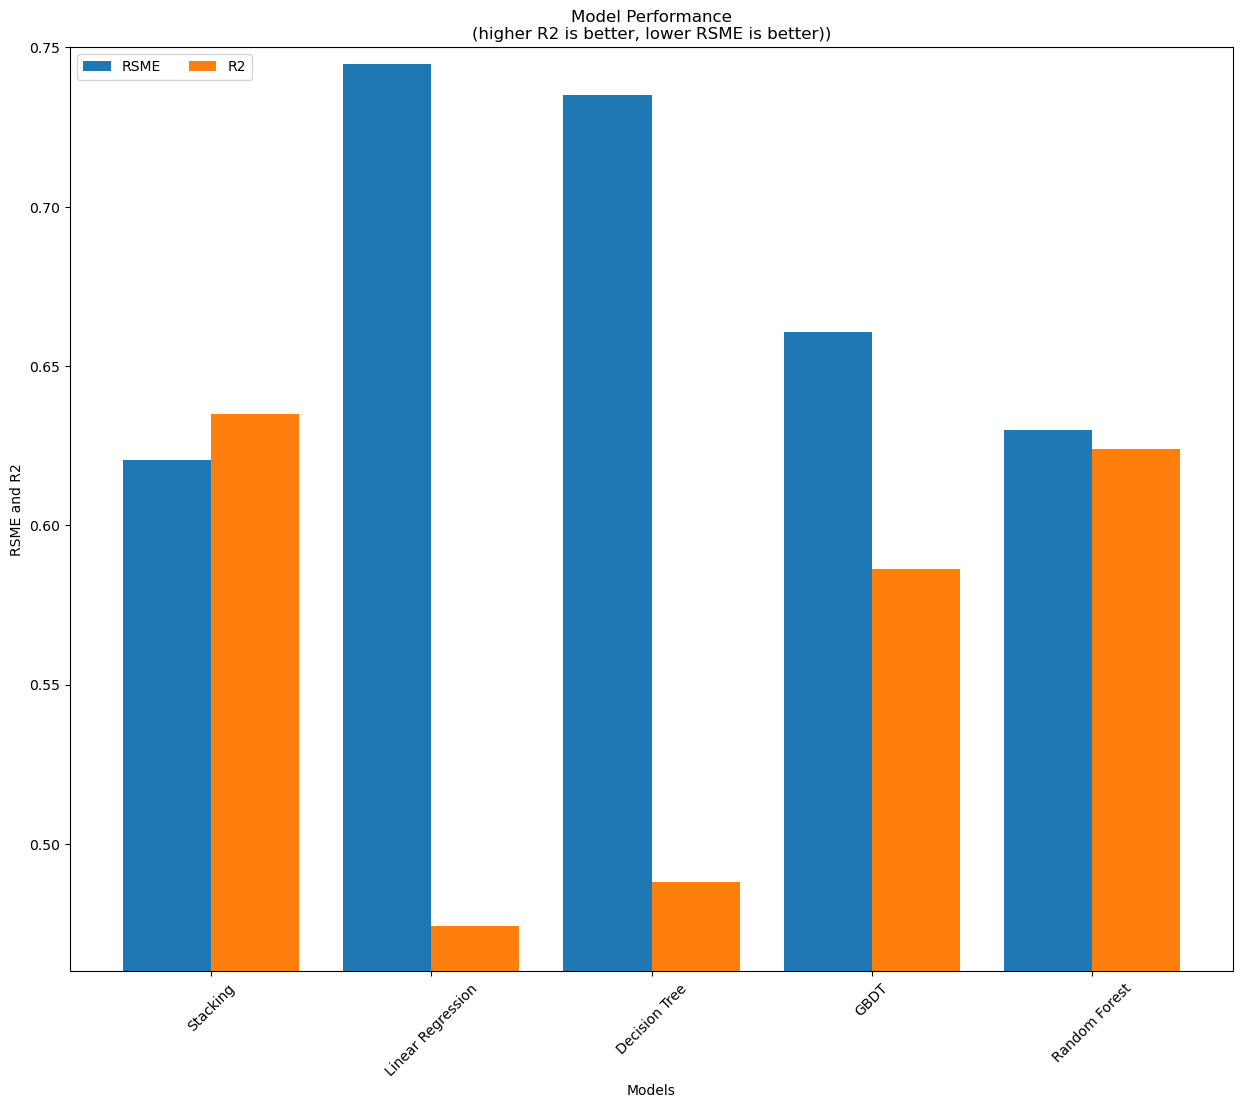

In [42]:
# create lists of the results from previous runs
alg_names    = ['Stacking', 'Linear Regression', 'Decision Tree', 'GBDT', 'Random Forest']
# training runtimes as manually recorded from above
runtimes_in_sec = [163, 0.180, 0.166, 9.31, 14.9]            # Macbook Pro 2017, with n_jobs=-1 and pyarrow backend

RMSE_Results = [rmse, lr_rmse, dt_rmse, gbdt_rmse, rf_rmse]
R2_Results   = [r2, lr_r2, dt_r2, gbdt_r2, rf_r2]

rg = np.arange(5)
width = 0.35

# Create bar plot with RMSE results
fig = plt.figure(figsize=(15,12))
plt.bar(rg - 0.2, RMSE_Results, 0.4, label = 'RSME')

# Create bar plot with R2 results
plt.bar(rg + 0.2, R2_Results,   0.4, label = 'R2') 

# label each model's name
plt.xticks(rg, alg_names, rotation=45)

# Label the x (Models) and y axis (RSME and R2) of the plot
plt.xlabel("Models")
plt.ylabel("RSME and R2")
#plt.ylim([0,1])
plt.ylim([0.46, 0.75])        # zoom in
plt.title("Model Performance\n(higher R2 is better, lower RSME is better))")
plt.legend(loc='upper left', ncol=2)
plt.show()

# Training time Analysis

/usr/local/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


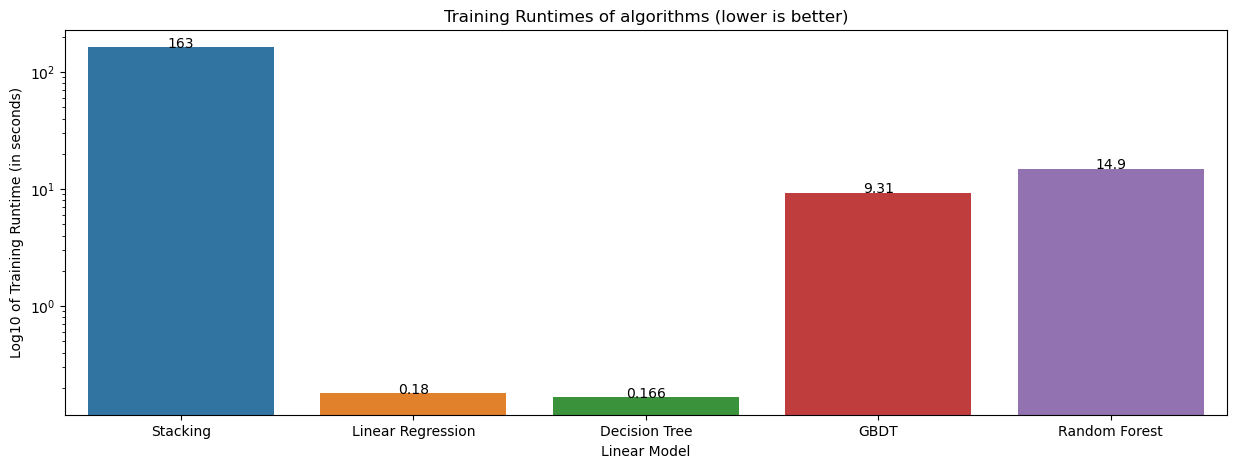

In [43]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x=alg_names, y=runtimes_in_sec)
addlabels(alg_names, runtimes_in_sec)

plt.title('Training Runtimes of algorithms (lower is better)')

g = ax.set_xlabel('Linear Model')
g = ax.set_ylabel('Log10 of Training Runtime (in seconds)')

ax.set_yscale("log")

## Future work:

### Hyperparameter tuning & Model Selection:
* Randomize the feature subset selection
* Removing some of the lower performing models like LinearRegression from the stacking model
* Vary and optimize individual model's hyperparameters that haven't been optimized yet, such as 
    DecisionTreeRegressor: max_features
    RandomForestRegressor: criterion, max_leaf_nodes, min_samples_split
    GradientBoostingRegressor: criterion, learning_rate, loss, max_depth, max_features
    LinearRegression: none really
* Investigate additional cross validation values- try 2 and 4 since it seemed to peak at 3 when given 1,3,5
* Try different methods of combining the stacked models, aka final_estimator

### Feature engineering:

* Resample the most expensive AirBnB listings to give them more representation to improve model performance at the higher end of the price range, or I would futher winsorize the price. - see figure below.
* Investigate dropping features that have low correlation with the label (price).
* Investigate dropping features that have high correlation with other features - see figure below.
* Investigate winsorizing additional features to reduce outliers - see figure showing highest z-scores below

### Exploratory Data Analysis:
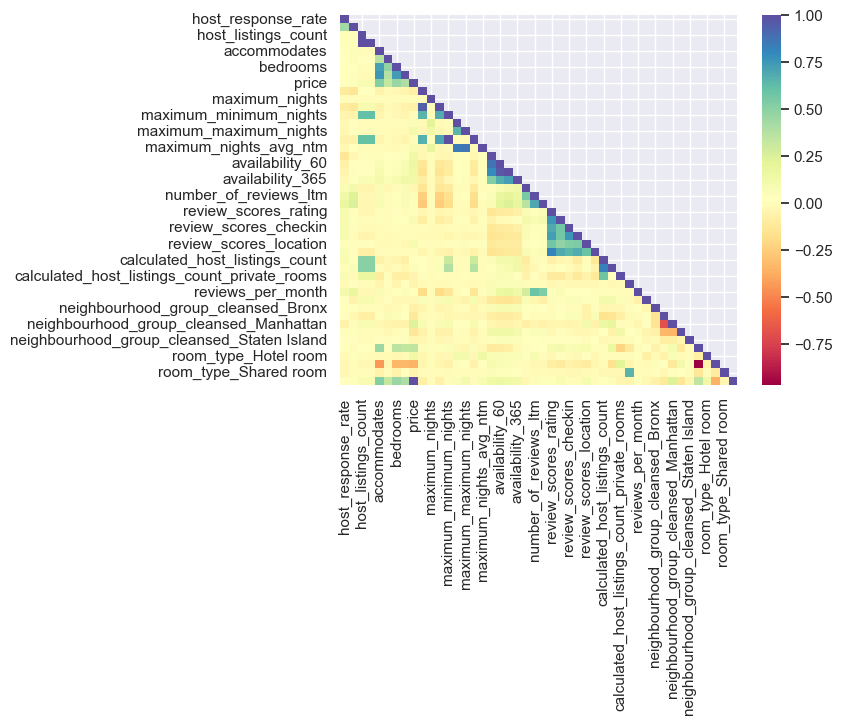

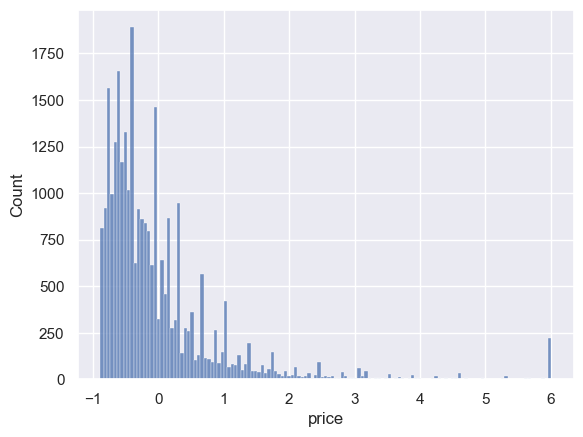

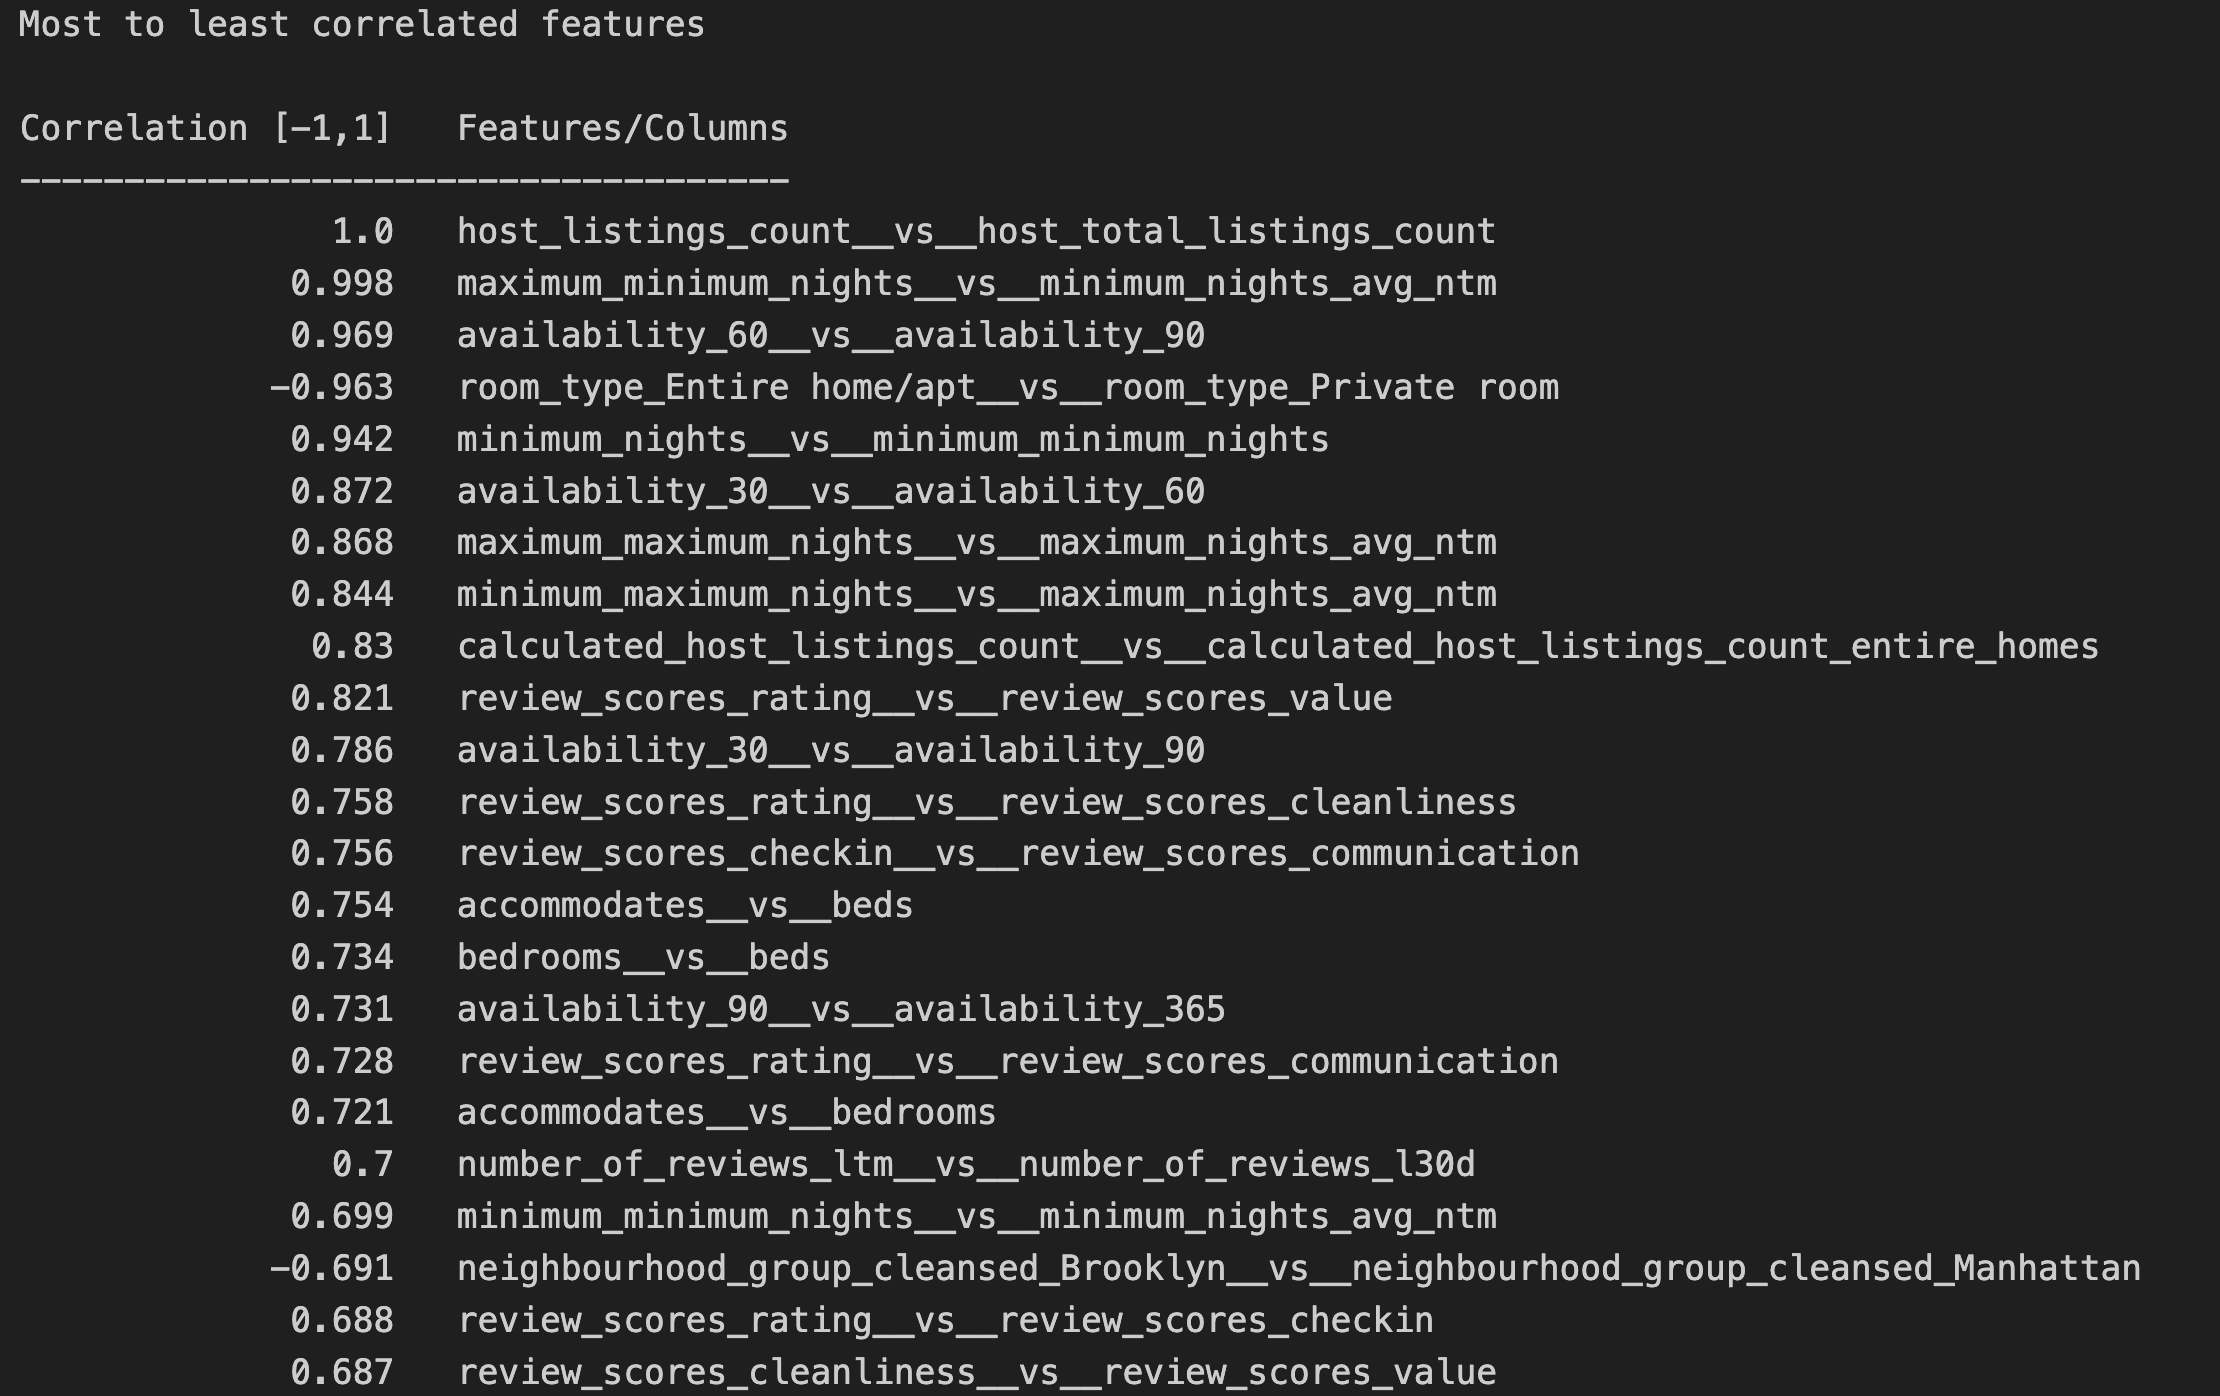

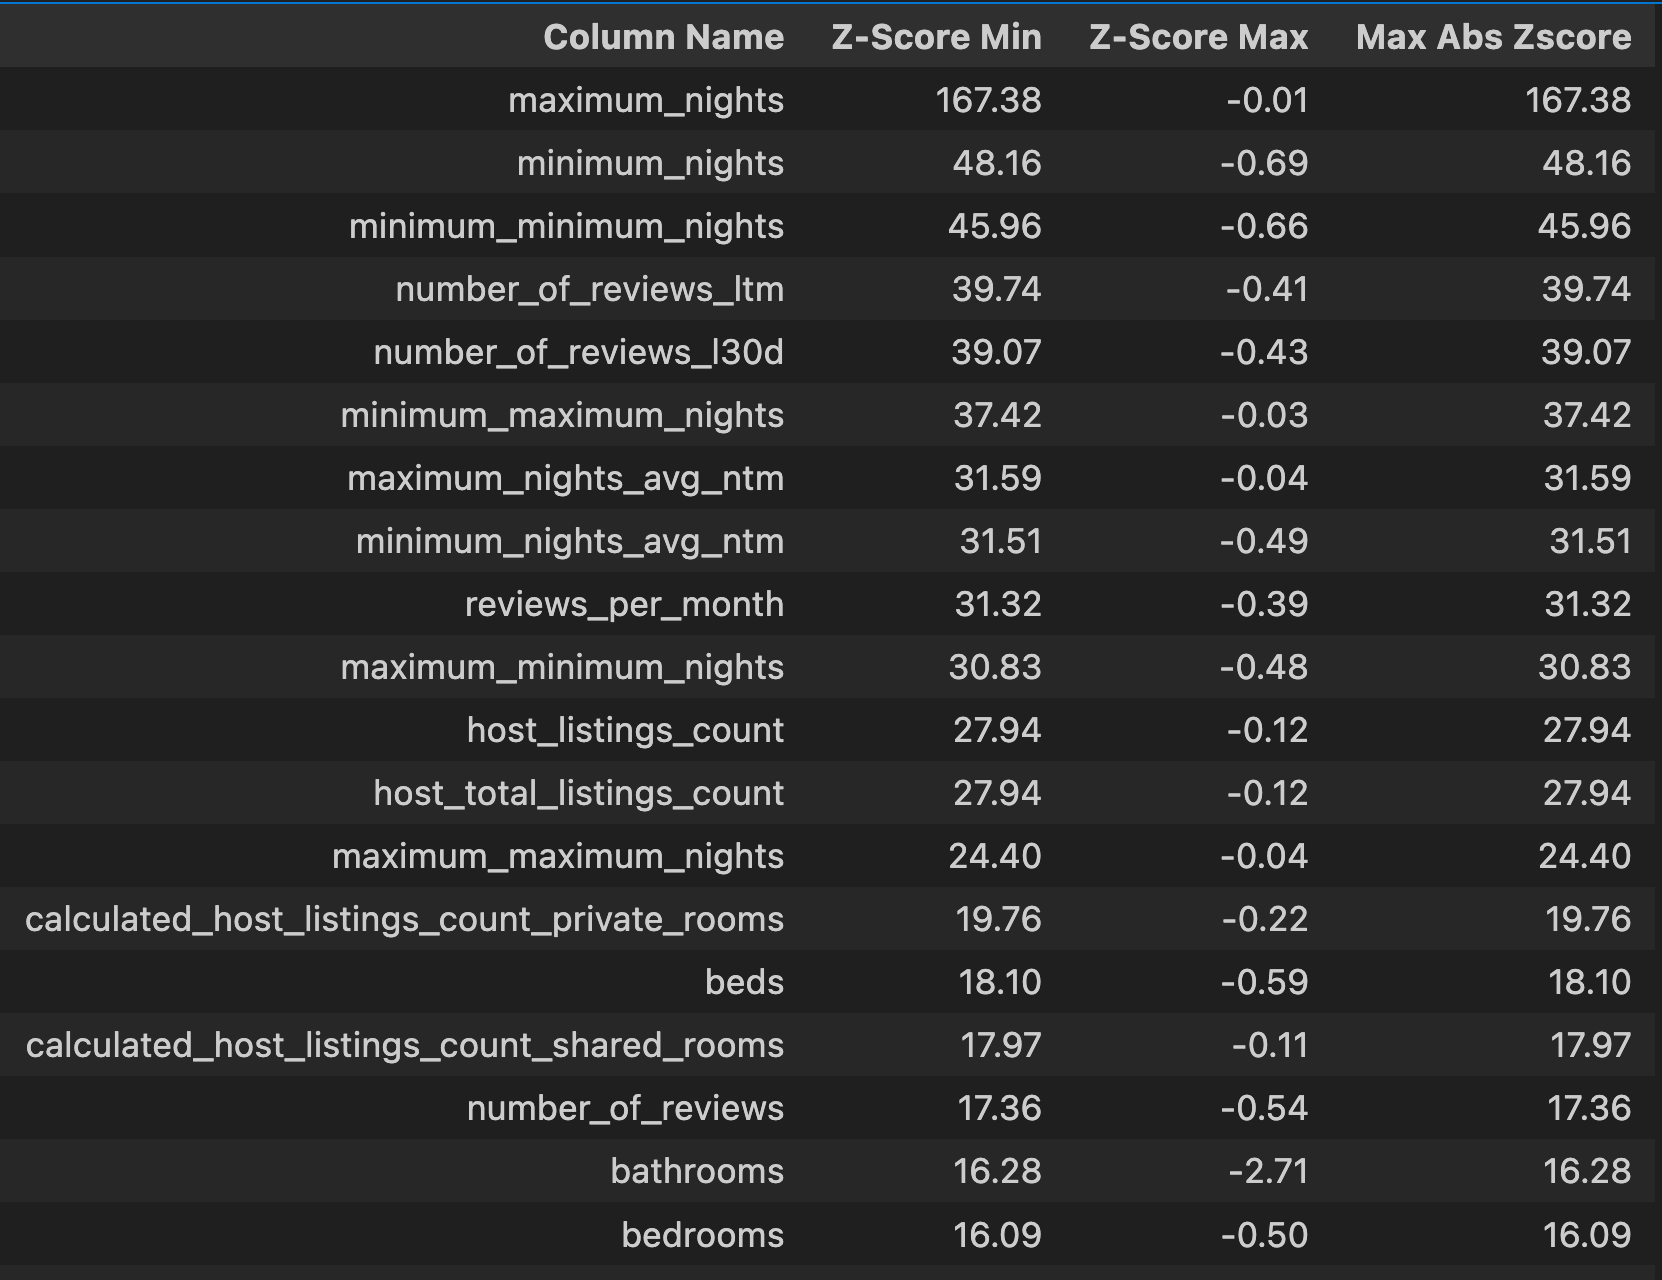